### Motivation

In this notebook we are going to implement a gaussian process. Here,

$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})$

Here $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ and $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$, where $m$ is a mean function and $K$ is a covariance function. 

We can convert GP prior $p(\mathbf{f} \lvert \mathbf{X})$ into $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after observing some data $y$. We can use the posterior to make prediction $\mathbf{f}_*$ given some new point $\textbf{X}_*$.

$p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) = \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)$ where $\mu_*$ and $\Sigma_*$ are mean and covariance of this posterior predictive distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import scipy.stats as st
from numpy.linalg import inv
sb.set()
%matplotlib inline

Custom function for plotting GP plot.

In [2]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.figure(figsize=(16,6))
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu)
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')

Lets define the Squared Exponential Kernel.

$\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))$

In [3]:
def kern(x1, x2, l=1.0, sigma_f=1.0):

    exp_part = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * exp_part)

Lets Calculate Prior.

In [4]:
n = 50

x = np.linspace(0,10,n).reshape(-1,1)

In [5]:
mu = np.zeros(x.shape)
cov = kern(x, x)

sample = np.random.multivariate_normal(mu.ravel(), cov, 12)

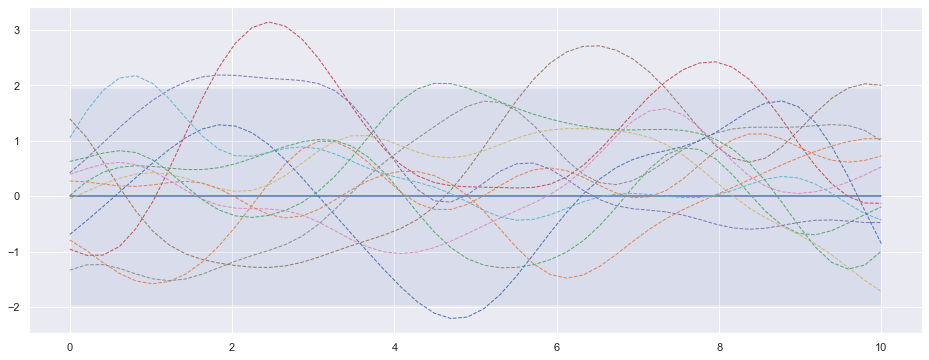

In [6]:
plot_gp(mu, cov, x, samples=sample)

In [7]:
x_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
y_train = np.sin(x_train)

print(x_train.shape)
print(y_train.shape)

(5, 1)
(5, 1)


In [8]:
x_s = np.arange(-5, 5, 0.2).reshape(-1, 1)
x_s.shape

(50, 1)

Create a function that will calculate mean and sigma for given train and test data.

$\mu_{*} = K_{*}^TK_{y}^{-1}y, \\
\Sigma_{*} = K_{**}-K_{*}^TK_{y}^{-1}K_{*}$

In [9]:
def posterior(x_s, x_train, y_train, l = 1.0, sigma_f = 1.0, sigma_y = 1e-8):
    
    K = kern(x_train, x_train, l, sigma_f) + sigma_y**2 * np.eye(len(x_train))
    
    K_s = kern(x_train, x_s, l, sigma_f)
    
    K_ss = kern(x_s, x_s, l, sigma_f) + 1e-8 * np.eye(len(x_s))
    
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(y_train)
    
    sigma_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, sigma_s

In [10]:
mu_s, sigma_s = posterior(x_s, x_train, y_train)

In [12]:
samples = np.random.multivariate_normal(mu_s.ravel(), sigma_s, 5)

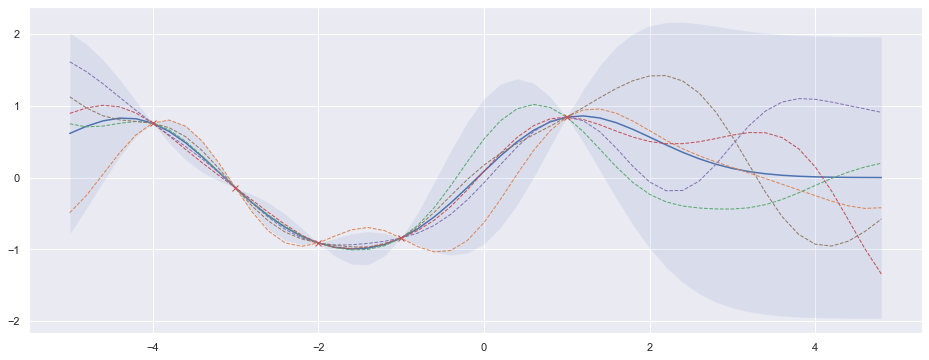

In [13]:
plot_gp(mu_s, sigma_s, x_s, X_train=x_train, Y_train= y_train, samples= samples)

Reference:

1. [An intuitive introduction to Gaussian processes](https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/)
2. [Blog Post](https://krasserm.github.io/2018/03/19/gaussian-processes/)
3. [Gaussian Process for Machine Learning: Chapter 2](http://www.gaussianprocess.org/gpml/)